In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem, Draw
import os
from multiprocessing import Pool

from rdkit.Chem.PropertyMol import PropertyMol # Allow pickle on mol props for multiprocessing
from rdkit.Chem import RDConfig # Allow Contrib packages to be used
from rdkit.Chem.Crippen import MolLogP as LogP # Lipophilicity
from rdkit.Chem.QED import default as QED # Quantitiative Estimate of Drug-likeness
from rdkit.Chem.Descriptors import MolWt # Mol Weight
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# add path for rdkit Contrib packages
from sascorer import calculateScore as SAS # Sythetic Accessiblilty Score

## Part 1 Combine, Rank, and Calculate Props for Generated Designs

### Combine all sd files from each cycle folder and calculate properties
This process is done automatically at the end of the main script of sample dock, however, if the task was killed by job scheduler before sample-and-dock could finish or any unexpected error occurred during the run, you can use the code below or post_process.py to combine and calculate the properties of each generated design.

In [2]:
# Directory to the generated designs (all the cycle folders)
directory = '/home/ziqiaoxu/VAE_Raw_Data/SnD-CDK2-5IEV-May21'
directory = os.path.abspath(directory)
print(directory)

/home/ziqiaoxu/VAE_Raw_Data/SnD-CDK2-5IEV-May21


In [3]:
# list of all cycle folders
folders = [x for x in os.listdir(directory) if x.startswith('cycle_')]
# sort folder name
folders.sort(key=lambda x: int(x.strip('cycle_')))
print(folders[-1])

cycle_145


In [4]:
#Function for calculate mol properties for sd files in each folder
def process_by_folder(fd):
    cycle = fd.strip("cycle_")
    sd = directory+'/'+fd+'/ranked_designs.sd'
    if os.path.exists(sd):
        cir_mols = [PropertyMol(m) for m in Chem.SDMolSupplier(sd)]
        for m in cir_mols:
            # Calculate properties for each mol
            m.SetProp('Cycle',cycle)
            m.SetProp('MolWeight', str(MolWt(m)))
            m.SetProp('LogP', str(LogP(m)))
            m.SetProp('QED', str(QED(m)))
            m.SetProp('SAS', str(SAS(m)))
        # Select the highest score design in the cycle
        # (the first one in the ranked sd file) 
        best_mol = cir_mols[0]
    return cir_mols, best_mol

In [5]:
# Multiprocessing on Mol Properties calculations
# Using all available threads minus one
with Pool(processes = os.cpu_count()-1) as pool:
    results = pool.map(process_by_folder, folders)

# Retrieve results
mol_lists, best_mols = zip(*results)
# Create the list of all mols
all_mols = []
for l in mol_lists:
    all_mols.extend(l)
# Convert tuple to list
best_mols = list(best_mols)

In [6]:
# Save mols in sdf files
with open(directory+'/All_Designs.sdf','w') as outfile:
    w = Chem.SDWriter(outfile)
    for m in all_mols:
        w.write(m)
    w.close()

with open(directory+'/Best_Designs.sdf','w') as outfile:
    w = Chem.SDWriter(outfile)
    for m in best_mols:
        w.write(m)
    w.close()

## Part 2 Make Pandas Dataframes, Plot Histograms on Mol Properties, and Draw Mols

### Load Saved Mol files and make Pandas dataframe
Load the `All_design.sdf` and `Best_Designs.sdf` generated by sample dock post processing

In [7]:
load_dir = '/home/ziqiaoxu/VAE_Raw_Data/SnD-CDK2-5IEV-May21/'
all_mols = [m for m in Chem.SDMolSupplier(load_dir+'/All_Designs.sdf')]
best_mols = [m for m in Chem.SDMolSupplier(load_dir+'/Best_Designs.sdf')]
# Generate 2D coordiantes for displaying better mol pics
for m in best_mols:
    AllChem.Compute2DCoords(m)

In [8]:
def create_df(mol_list):
    # Create a dataframe with all these mol properties
    # These props should exist if the designs are post-processed by sample-and-dock 
    mol_props = ['Name','Cycle','SCORE.INTER','SMILES','LogP','QED','MolWeight','SAS']
    df = pd.DataFrame()

    # Fill df with lists (append by entry using dicts from each mol increases data overhead and is slow)
    # It is considerably faster this way (about 400x) 
    for prop in mol_props:
        # Add a list of prop to df from the mol_list
        df[prop] = [m.GetProp(prop) for m in mol_list]
        # Convert strings to possible numeric dtypes
        try:
            inferred_type = pd.to_numeric(df[prop]).dtype
            df[prop] = df[prop].astype(inferred_type)
        except ValueError:
            pass

    # Add mol objects to the last column
    df['Mol'] = mol_list
    return df

In [9]:
# Create dataframe from the lists
allscores = create_df(all_mols)
minscores = create_df(best_mols)

# sort the dataframe based on docking scores
sortedscores = minscores.sort_values('SCORE.INTER')
# Drop dulicated entries
sortedscores.drop_duplicates('SMILES', inplace = True, keep = 'first')

minscores.describe()

,Cycle,SCORE.INTER,LogP,QED,MolWeight,SAS
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,72.500000,-23.014852,2.385945,0.735632,324.444705,2.035103
std,42.290661,5.915334,0.667455,0.078409,27.744191,0.296206
min,0.000000,-29.370600,0.707900,0.571949,150.177000,1.570086
25%,36.250000,-26.239600,1.912525,0.665804,314.231500,1.872320
50%,72.500000,-24.966850,2.359200,0.752221,326.397500,1.993992
75%,108.750000,-23.642225,2.902400,0.786771,339.299750,2.130113
max,145.000000,-8.917590,3.777600,0.935639,382.489000,3.987501


In [10]:
# Save as csv
allscores.drop(columns=['Mol']).to_csv(load_dir+'/allscores.csv', index = False)
sortedscores.drop(columns=['Mol']).to_csv(load_dir+'/sortedscores.csv', index = False)

,Name,Cycle,SCORE.INTER,SMILES,LogP,QED,MolWeight,SAS,Mol
11,design_8,11,-29.37060,NS(=O)(=O)c1cccc(NC(=O)c2cccc(Oc3cnccn3)c2)c1,2.16860,0.709082,370.390,2.100055,
114,design_18,114,-28.78160,Cc1nc(CCNC(=O)NCCc2nc3c(s2)CCCC3)cs1,2.87122,0.841710,350.513,2.555418,
33,design_9,33,-28.66800,CC1CCC(NC(=O)NCCc2ccc(S(N)(=O)=O)cc2)CC1,1.75440,0.761504,339.461,2.025788,
131,design_15,131,-28.57170,Cc1cccc(CCNC(=O)NCCc2nc3ccccc3[nH]2)c1,2.95572,0.652849,322.412,2.002148,
6,design_3,6,-28.14610,NS(=O)(=O)c1cccc(NC(=O)c2ccc3ccccc3c2)c1,2.73950,0.775294,326.377,1.696480,
...,...,...,...,...,...,...,...,...,...
67,design_3,67,-9.49658,CCN(CC(=O)OC)C(=O)c1sccc1Br,2.14570,0.800819,306.181,2.329974,
51,design_13,51,-9.43999,CCN(CCC(=O)OC)C(=O)Cc1ccc(C)cc1,1.94912,0.736944,263.337,1.873356,
61,design_11,61,-9.39865,CCN(CC(=O)OC)C(=O)c1ccccc1Br,2.08420,0.799905,300.152,1.916207,
15,design_3,15,-9.13884,COc1ccc2c(c1)OCC2,1.63010,0.605391,150.177,1.845944,

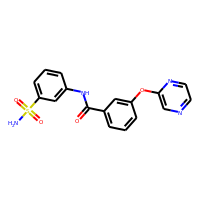
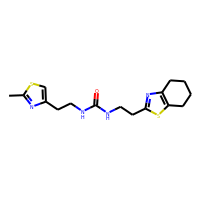
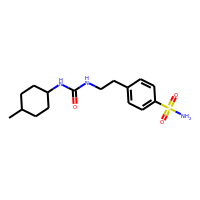
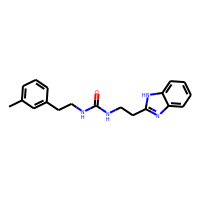
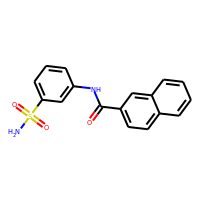
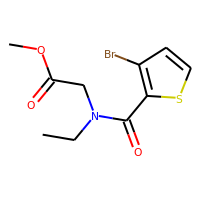
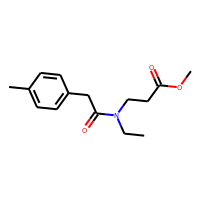
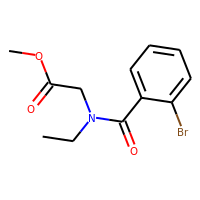
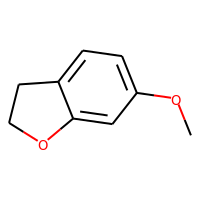
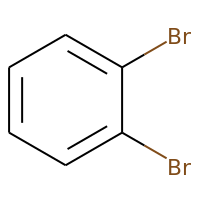

In [11]:
PandasTools.ChangeMoleculeRendering(renderer='PNG')
PandasTools.RenderImagesInAllDataFrames(images=True)
display(sortedscores)

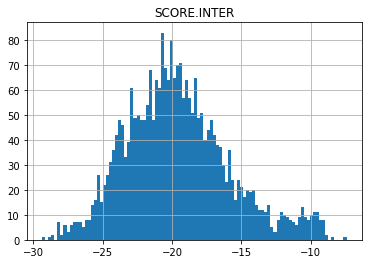

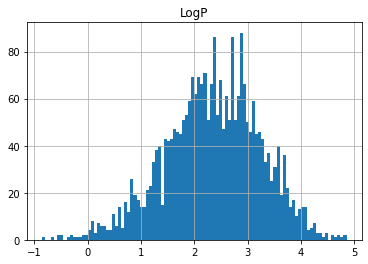

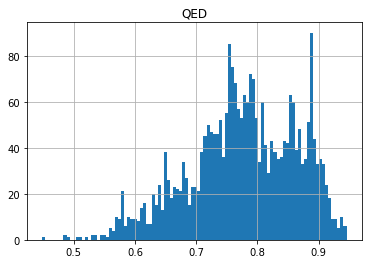

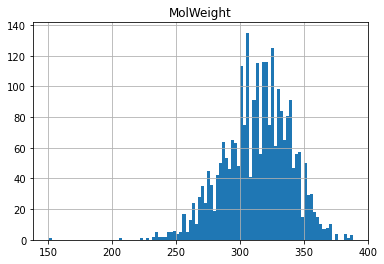

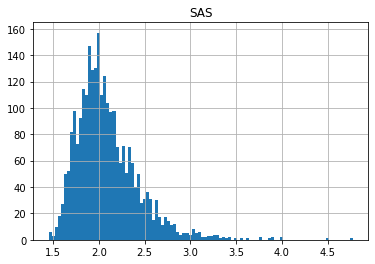

In [12]:
# plot histograms for the properties
import matplotlib.pyplot as plt
for c in allscores.columns:
    if allscores[c].dtype == float:
        allscores[c].hist(bins=100)
        plt.title(c)
        plt.show()

### Draw molecules

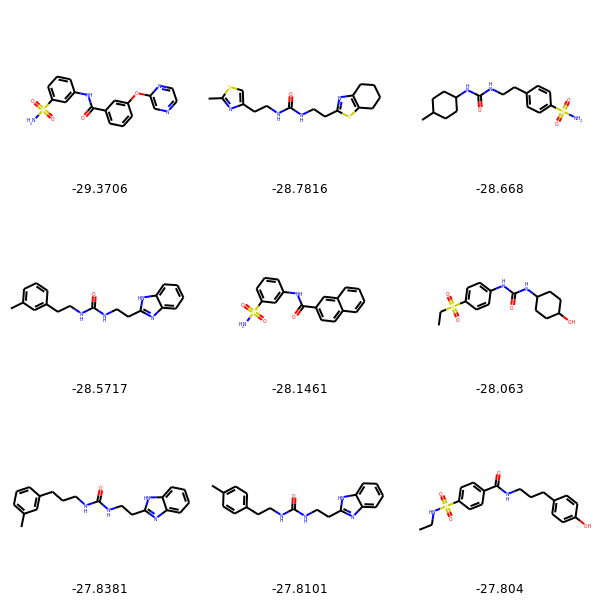

In [13]:
# Showing the top 9 here
PandasTools.FrameToGridImage(sortedscores[:9], column='Mol', legendsCol='SCORE.INTER')

### Draw higher quality mol pics using svg

In [14]:
# Set labels using docking scores
l = [str(x)+' kcal/mol' for x in sortedscores["SCORE.INTER"].to_list()]
# Draw top 30 mol svg
svg = Draw.MolsToGridImage(sortedscores.Mol[:30], subImgSize = (300,300), legends = l, useSVG =True)

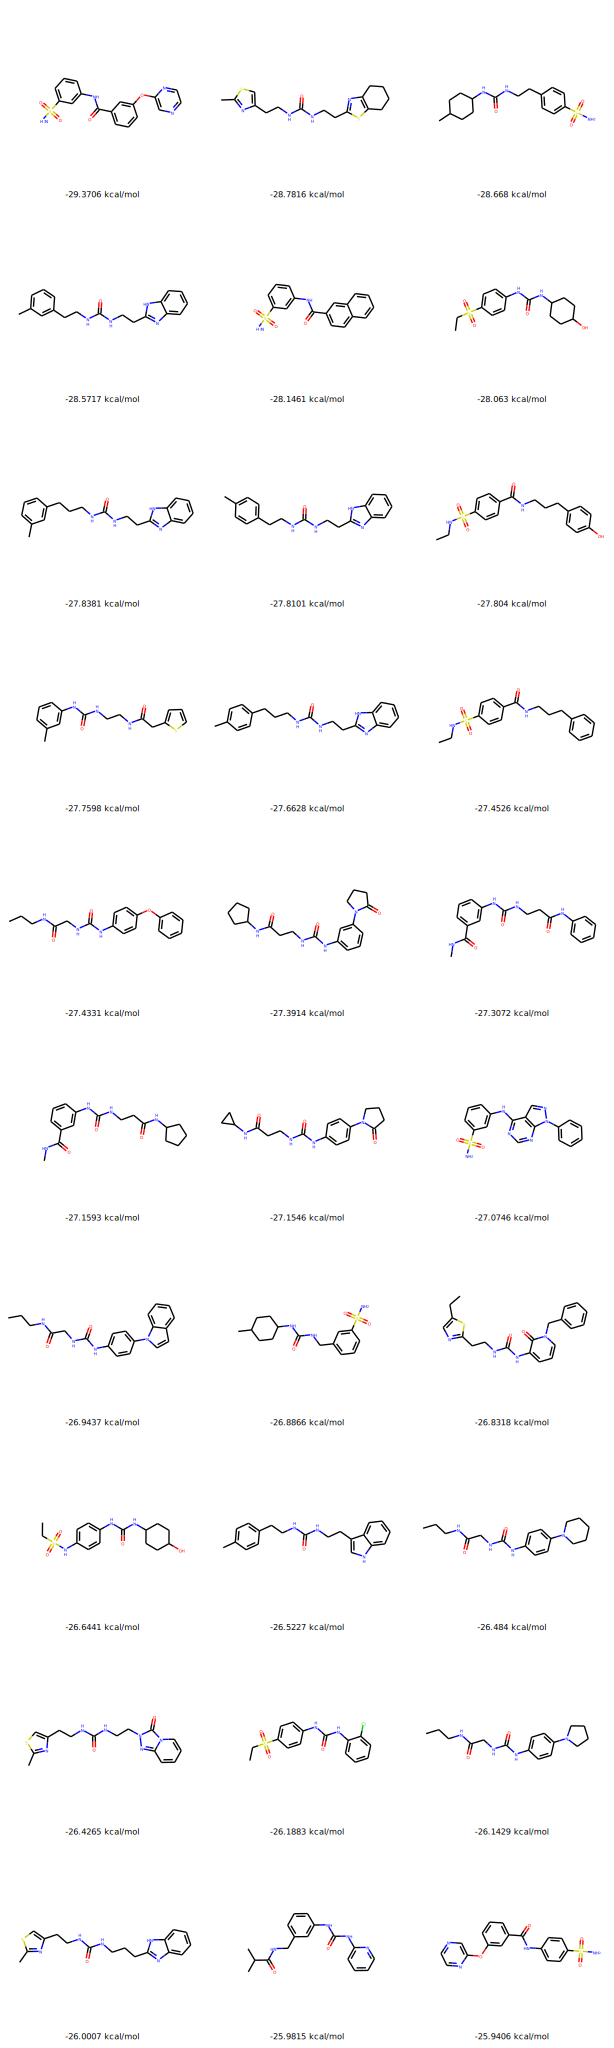

In [15]:
display(svg)

In [16]:
# Save svg image
with open(load_dir+'/Designs.svg','w') as f:
    f.write(svg.data)